# Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms

from PIL import Image, ImageOps

from models.unet import build_unet

In [3]:
# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Load weights
model_path = "./logs/hma_unet/hma_unet.pth"
model = build_unet()
model.load_state_dict(torch.load(model_path))
model = model.to(DEVICE)
model.eval()

# TODO
# train -> torch.save(mode, PATH)
# test -> model = torch.load(PATH)
#         model.eval()

cuda:0


build_unet(
  (e1): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): encoder_block(
    (conv): conv_block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2

### Helpers

In [4]:
def read_image(image_path):
    assert type(image_path) == str, f"Should be a path, got: {image_path} which is {type(image_path)}"
    img = Image.open(image_path)
    return img

def _convert_image_to_rgb(image):
    return image.convert("RGB")

def predict(input_image):
    
    preprocess = transforms.Compose([transforms.Resize((512, 256)),
                                     transforms.CenterCrop((512, 256)),
                                     _convert_image_to_rgb,
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5),
                                                          (0.5, 0.5, 0.5))
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    input_batch = input_batch.to(DEVICE)
    with torch.no_grad():
        out = torch.sigmoid(model(input_batch.float()))
    
    # resize to original image size
    out = torch.nn.functional.interpolate(out, 
                                          size=(input_image.size[1], input_image.size[0]), 
                                          mode='bicubic',
                                          align_corners=True)
    out = out.permute(0, 2, 3, 1).squeeze().detach().cpu().numpy() > 0.5
    out=(out*255).astype(np.uint8)
    out = Image.fromarray(np.uint8(out)).convert('RGB')
    return out
    

### Make a prediction

In [5]:
path = "./datasets/human_artifacts/train/humans/3989.png"
image = read_image(path)

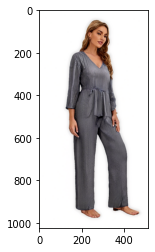

In [6]:
plt.imshow(image)

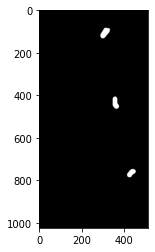

In [7]:
mask = predict(image)
plt.imshow(mask)

In [8]:
mask.save("notebooks/prediction.png")